In [1]:
import egglib
import glob 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

Load in each vcf split by chromosome to speed up processing, and validate that everything is formed correctly 

In [2]:
#import CDS vcf filtered to relevant samples and to chromosome 1
vcf_path='/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_1_cds.recode.clean.vcf'
vcf=egglib.io.VcfParser(vcf_path)

egglib.io.make_vcf_index(vcf_path)
vcf.load_index(vcf_path+'i')
vcf

In [14]:
directory='/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/'
files = glob.glob(os.path.join(directory, "nlrome_partial_*_cds.recode.clean.vcf"))
files.sort()
print(files)

def importer(vcf_path):
    vcf=egglib.io.VcfParser(vcf_path)
    egglib.io.make_vcf_index(vcf_path)
    vcf.load_index(vcf_path+'i')
    return vcf

vcf1=importer(files[0])
vcf2=importer(files[1])
vcf3=importer(files[2])
vcf4=importer(files[3])
vcf5=importer(files[4])

['/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_1_cds.recode.clean.vcf', '/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_2_cds.recode.clean.vcf', '/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_3_cds.recode.clean.vcf', '/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_4_cds.recode.clean.vcf', '/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_5_cds.recode.clean.vcf']


In [15]:
#check to make sure everything is clean. Delete problematic lines with sed (only a few, and repeat until passes)
def parse_check(vcf, chrom):
    vcf.goto(chrom, position=egglib.io.FIRST)
    ln=0
    for i in vcf:
        ln += 1
        try: 
            chrom, pos, nall=next(vcf)
            #print(chrom, pos, nall)
        except:
            print('error line', ln)
            #next(vcf)
    return print('checked')

print(files[0])
parse_check(vcf1, '1')
print(files[1])
parse_check(vcf2, '2')
print(files[2])
parse_check(vcf3, '3')
print(files[3])
parse_check(vcf4, '4')
print(files[4])
parse_check(vcf5, '5')

/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_1_cds.recode.clean.vcf
checked
/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_2_cds.recode.clean.vcf
checked
/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_3_cds.recode.clean.vcf
checked
/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_4_cds.recode.clean.vcf
checked
/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_5_cds.recode.clean.vcf
checked


Cool, all the CDS VCFs look clean and are ready to be processed.

In [17]:
#check sample and index information 
print(vcf1.num_samples)
print(vcf1.has_index)
print(vcf2.num_samples)
print(vcf2.has_index)
print(vcf3.num_samples)
print(vcf3.has_index)
print(vcf4.num_samples)
print(vcf4.has_index)
print(vcf5.num_samples)
print(vcf5.has_index)

55
True
55
True
55
True
55
True
55
True


In [5]:
#Create a bed file with single transcripts CDS coordinates, using the GTF file from Araport11
gtf='/global/scratch/users/chandlersutherland/Athaliana/GTFs/Araport11_GTF_genes_transposons.current.gtf'
gtf_import=pd.read_csv(gtf,sep='\t', skiprows=3).reset_index()
gtf_import=gtf_import.rename(columns={"level_0": "chrom", "level_1": "Genome", "level_2" : "type", "level_3" : "chromStart", "level_4":"chromEnd", "level_6":'strand'})
gtf_import['name'] = gtf_import['##GTF'].str.split(';',expand=True)[1].str.split(' ', expand=True)[2].str.replace('"', '')


#filter to CDS only and filter to only transcript 1. This will also speed up computation 
cds_import=gtf_import[gtf_import['type'] == 'CDS']
cds_import['name'] = cds_import['##GTF'].str.split(';',expand=True)[1].str.split(' ', expand=True)[2].str.replace('"', '')
cds_import['transcript_id']=cds_import['##GTF'].str.split(';',expand=True)[0].str.split(' ', expand=True)[1].str.strip('"').str.split('.', expand=True)[1]
cds_import['chrom']=cds_import['chrom'].str.replace('Chr', '')
cds_import=cds_import[cds_import['transcript_id']=='1']

bed_ready2 = cds_import.drop(['Genome', 'type', 'level_5', 'level_7', '##GTF'], axis=1)
bed_ready2=bed_ready2.rename(columns={'chromStart':'bedStart', 'chromEnd':'bedEnd'})[['chrom', 'bedStart', 'bedEnd', 'name']]
bed_ready2

bed_g=bed_ready2.groupby(['name'])

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launch

In [6]:
#function that takes chromosome, CDS start, and CDS end, then returns an array with the vcf sites in that zone
def exon_search(bed_chrom, bed_start, bed_end, vcf):
    array=[]
    for i in vcf:
        chrom, pos, nall = next(vcf)
        if int(chrom) == bed_chrom:
            if pos >= bed_start and pos <= bed_end:
                site=vcf.get_genotypes()
                array.append(site)
            if pos > bed_end:
                break
    return array

In [7]:
#takes in CDS, harvests sites for each piece of the CDS, then calculate over it 
def combine_cds(one_gene, vcf):
    cs = egglib.stats.ComputeStats()
    cs.configure(multi_hits=True, multi=False)
    cs.add_stats('Pi', 'lseff', 'D')

    sites=[]
    cds_length=0
    for index, row in one_gene.iterrows():
        bed_chrom=int(row['chrom'])
        bed_start=int(row['bedStart'])
        bed_end=int(row['bedEnd'])
        cds_length += bed_end-bed_start
        results=exon_search(bed_chrom, bed_start, bed_end, vcf)
        sites.extend(results)

    stats=cs.process_sites(sites)
    
    lseff=stats['lseff']
    D=stats['D']
    if pd.isnull(stats['D']):
        D=np.nan
    Pi=stats['Pi']
        
    gene=one_gene.iloc[0,3]
    result={'gene':gene, 'Pi_raw':Pi, 'D':D, 'lseff':lseff, 'cds_length':cds_length}
    return result



In [20]:
#beginning with chrom1 
bed_g=bed_ready2.groupby(['name'])

genes_1=bed_ready2[bed_ready2['chrom']=='1']['name'].unique()
genes_1

chrom1_stats=pd.DataFrame()
#put this here to start from beginning, but save time by not restarting as you move along 
vcf1.goto('1', position=egglib.io.FIRST)
for i in genes_1:
    sub=bed_g.get_group(i)
    result=combine_cds(sub, vcf1)
    chrom1_stats=chrom1_stats.append(result, ignore_index=True)
    
chrom1_stats

,D,Pi,cds_length,gene,lseff
0,0.034758,0.196163,1284.0,AT1G01010,11.0
1,-0.204950,0.684199,729.0,AT1G01020,7.0
2,-0.821854,0.442834,1076.0,AT1G01030,13.0
3,-1.801743,1.76735,5710.0,AT1G01040,64.0
4,NaN,None,631.0,AT1G01050,0.0
...,...,...,...,...,...
7138,-0.451623,0.427242,1189.0,AT1G80950,11.0
7139,-1.339005,4.86344,1455.0,AT1G80960,79.0
7140,0.206193,0.857143,643.0,AT1G80970,3.0
7141,NaN,None,641.0,AT1G80980,0.0


Could have made this into a function, but here's the calculation per chromosome:

In [22]:
#beginning with chrom1, get unique gene names  
genes_1=bed_ready2[bed_ready2['chrom']=='1']['name'].unique()
genes_1

#initialize results df 
chrom1_stats=pd.DataFrame()

#put this here to start from beginning, but save time by not restarting as you move along 
vcf1.goto('1', position=egglib.io.FIRST)

#get df of coordinates of CDS, then calculate stats across it, then write to df 
for i in genes_1:
    sub=bed_g.get_group(i)
    result=combine_cds(sub, vcf1)
    chrom1_stats=chrom1_stats.append(result, ignore_index=True)

print('finished chrom1')
chrom1_stats
    
#repeat for remaining chromosomes 
genes_2=bed_ready2[bed_ready2['chrom']=='2']['name'].unique()
genes_2

chrom2_stats=pd.DataFrame()
#put this here to start from beginning, but save time by not restarting as you move along 
vcf2.goto('2', position=egglib.io.FIRST)
for i in genes_2:
    sub=bed_g.get_group(i)
    result=combine_cds(sub, vcf2)
    chrom2_stats=chrom2_stats.append(result, ignore_index=True)
    
print('finished chrom2')
chrom2_stats

#chrom3
genes_3=bed_ready2[bed_ready2['chrom']=='3']['name'].unique()
genes_3

chrom3_stats=pd.DataFrame()
#put this here to start from beginning, but save time by not restarting as you move along 
vcf3.goto('3', position=egglib.io.FIRST)
for i in genes_3:
    sub=bed_g.get_group(i)
    result=combine_cds(sub, vcf3)
    chrom3_stats=chrom3_stats.append(result, ignore_index=True)

print('finished chrom3')
chrom3_stats


#chrom4
genes_4=bed_ready2[bed_ready2['chrom']=='4']['name'].unique()

chrom4_stats=pd.DataFrame()
#put this here to start from beginning, but save time by not restarting as you move along 
vcf4.goto('4', position=egglib.io.FIRST)
for i in genes_4:
    sub=bed_g.get_group(i)
    result=combine_cds(sub, vcf4)
    chrom4_stats=chrom4_stats.append(result, ignore_index=True)
    
print('finished chrom4')
chrom4_stats

#chrom5
genes_5=bed_ready2[bed_ready2['chrom']=='5']['name'].unique()
genes_5

chrom5_stats=pd.DataFrame()
#put this here to start from beginning, but save time by not restarting as you move along 
vcf5.goto('5', position=egglib.io.FIRST)
for i in genes_5:
    sub=bed_g.get_group(i)
    result=combine_cds(sub, vcf5)
    chrom5_stats=chrom5_stats.append(result, ignore_index=True)

print('finished chrom5')
chrom5_stats

finished chrom1
finished chrom2
finished chrom3
finished chrom4
finished chrom5


,D,Pi_raw,cds_length,gene,lseff
0,-1.429474,0.110758,1302.0,AT5G01010,9.0
1,-1.319189,0.145379,313.0,AT5G01015,11.0
2,NaN,None,254.0,AT5G01017,0.0
3,-0.944377,0.144746,1228.0,AT5G01020,16.0
4,-1.926804,0.688045,2233.0,AT5G01030,64.0
...,...,...,...,...,...
6318,NaN,None,246.0,AT5G67600,0.0
6319,0.499195,2.93667,1451.0,AT5G67610,26.0
6320,-0.251609,0.489753,546.0,AT5G67620,7.0
6321,-0.510494,1.03856,1408.0,AT5G67630,14.0


In [31]:
#combine and write out the results 
results=[chrom1_stats, chrom2_stats, chrom3_stats, chrom4_stats, chrom5_stats]
cds_stats=pd.concat(results)
#normalize pi by CDS DNA length (pi/bp) and by site (pi/site)
cds_stats['Pi_by_dna']=cds_stats['Pi_raw']/cds_stats['cds_length']
cds_stats['Pi_by_lseff']=cds_stats['Pi_raw']/cds_stats['lseff']

cds_stats.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/cds_egglib_wholegenome2.csv')

Let's examine the distribution of the calculated statistics 

mean D:  -0.4454416524799366
median D:  -0.6903334181226258


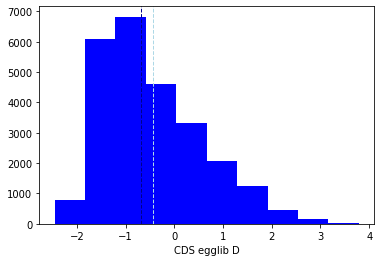

In [24]:
cds_stats=cds_stats.dropna()

mean=cds_stats['D'].mean()
print('mean D: ', mean)
median=cds_stats['D'].median()
print('median D: ', median)

plt.hist(cds_stats['D'], color='blue')
plt.axvline(mean, color='lightblue', linestyle='dashed', linewidth=1)
plt.axvline(median, color='darkblue', linestyle='dashed', linewidth=1)
plt.xlabel("CDS egglib D")

plt.show()

mean Pi:  0.002093612147348332
median Pi:  0.001339140420094906


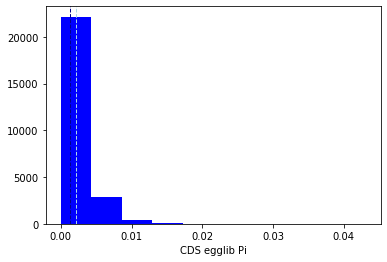

In [30]:
mean=cds_stats['Pi_by_dna'].mean()
print('mean Pi: ', mean)
median=cds_stats['Pi_by_dna'].median()
print('median Pi: ', median)

plt.hist(cds_stats['Pi_by_dna'], color='blue')
plt.axvline(mean, color='lightblue', linestyle='dashed', linewidth=1)
plt.axvline(median, color='darkblue', linestyle='dashed', linewidth=1)
plt.xlabel("CDS egglib Pi")

plt.show()

Check out 1001 genomes..

In [3]:
vcf_path='/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/1001genomes_snp-short-indel_only_ACGTN.vcf'
vcf=egglib.io.VcfParser(vcf_path)

egglib.io.make_vcf_index(vcf_path)
vcf.load_index(vcf_path+'i')

In [8]:
#beginning with chrom1, get unique gene names  
genes_1=bed_ready2[bed_ready2['chrom']=='1']['name'].unique()
genes_1

#initialize results df 
chrom1_stats=pd.DataFrame()

#put this here to start from beginning, but save time by not restarting as you move along 
vcf.goto('1', position=egglib.io.FIRST)

#get df of coordinates of CDS, then calculate stats across it, then write to df 
for i in genes_1:
    sub=bed_g.get_group(i)
    result=combine_cds(sub, vcf)
    chrom1_stats=chrom1_stats.append(result, ignore_index=True)

print('finished chrom1')
chrom1_stats
    

OSError: cannot parse "VCF" data from "/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/1001genomes_snp-short-indel_only_ACGTN.vcf" (line 33879): invalid GT field: 11|11

In [13]:
pi_normal=chrom1_stats["Pi_raw"]/chrom1_stats['cds_length']
pi_normal.mean()

0.0011042143501993245

Check out chromosome 1 gene instead of CDS

In [3]:
#import vcf filtered to relevant samples
vcf_path='/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial_1_gene.recode.clean.vcf'
vcf=egglib.io.VcfParser(vcf_path)

egglib.io.make_vcf_index(vcf_path)
vcf.load_index(vcf_path+'i')

In [40]:
#load gene bed file 
bed_gene=pd.read_csv('/global/scratch/users/chandlersutherland/Athaliana/Atha_genes.recode.bed', sep='\t', names=['chrom', 'bedStart', 'bedEnd', 'strand', 'name']).reset_index()
bed_gene=bed_gene.drop(['index'], axis=1)
bed_gene['chrom']=bed_gene['chrom'].str.replace('Chr', '')
#filter to only genes that have a CDS (not a weird lncRNA or something)
coding=bed_gene[bed_gene['name'].isin(bed_cds['name'])]
coding=coding[coding['chrom']=='1']
coding['chrom']=coding['chrom'].astype('int')
coding 

#bed_cds['name']

,chrom,bedStart,bedEnd,strand,name
0,1,3631,5899,+,AT1G01010
1,1,6788,9130,-,AT1G01020
2,1,11649,13714,-,AT1G01030
3,1,23121,31227,+,AT1G01040
5,1,31170,33171,-,AT1G01050
...,...,...,...,...,...
8766,1,30412149,30415264,-,AT1G80950
8767,1,30415123,30419047,+,AT1G80960
8768,1,30420102,30421995,+,AT1G80970
8769,1,30422050,30424152,-,AT1G80980


In [106]:
vcf.goto('1', position=egglib.io.FIRST)

bed_start1=6788
bed_end1=9130
bed_chrom1=1

array=[]
for i in vcf:
    chrom, pos, nall = next(vcf)
    if int(chrom) == bed_chrom1:
        if pos >= bed_start1 and pos <= bed_end1:
            site=vcf.get_genotypes()
            array.append(site)
        if pos > bed_end1:
            break
#print(array)


vcf.goto('1', position=egglib.io.FIRST)
print(exon_search(bed_chrom1, bed_start1, bed_end1))

[<egglib._site.Site object at 0x2b56db1cf690>, <egglib._site.Site object at 0x2b56db1cf4d0>, <egglib._site.Site object at 0x2b56db1cf2d0>, <egglib._site.Site object at 0x2b56db1cffd0>, <egglib._site.Site object at 0x2b56db1cf590>, <egglib._site.Site object at 0x2b56db1cf750>, <egglib._site.Site object at 0x2b56db1cf7d0>, <egglib._site.Site object at 0x2b56db1cf090>, <egglib._site.Site object at 0x2b56db1cfe50>, <egglib._site.Site object at 0x2b56db1cfe10>, <egglib._site.Site object at 0x2b56db1cf390>, <egglib._site.Site object at 0x2b56db1cfad0>, <egglib._site.Site object at 0x2b56db1cfc10>, <egglib._site.Site object at 0x2b56db1cf850>, <egglib._site.Site object at 0x2b56db1cfd10>, <egglib._site.Site object at 0x2b56dcb78b90>, <egglib._site.Site object at 0x2b56e00f7450>, <egglib._site.Site object at 0x2b56e00f7fd0>, <egglib._site.Site object at 0x2b56e00f74d0>, <egglib._site.Site object at 0x2b56e00f7a90>, <egglib._site.Site object at 0x2b56e00f7590>, <egglib._site.Site object at 0x2b

In [103]:
#check to make sure everything is clean. Delete problematic lines with sed (only a few, and repeat until passes)
vcf.goto('1', position=egglib.io.FIRST)
ln=0
for i in vcf:
    ln += 1
    try: 
        chrom, pos, nall=next(vcf)
        #print(chrom, pos, nall)
    except:
        print('error line', ln)
        #next(vcf)

In [42]:
vcf.goto('1', position=egglib.io.FIRST)
gene_results=coding
gene_results['D']=np.nan
gene_results['Pi']=np.nan
for index, row in coding.iterrows():
    cs = egglib.stats.ComputeStats()
    cs.add_stats('Pi', 'lseff', 'D')
    
    bed_chrom=int(row['chrom'])
    bed_start=int(row['bedStart'])
    bed_end=int(row['bedEnd'])
    results=exon_search(bed_chrom, bed_start, bed_end)
    
    stats=cs.process_sites(results)
    
    lseff=stats['lseff']
    D=stats['D']
    if pd.isnull(stats['D']):
        D=np.nan
    if lseff == 0:
        Pi=np.nan
    else:
        Pi=stats['Pi']/lseff
    
    gene_results.loc[index, 'D']=D
    gene_results.loc[index, 'Pi']=Pi
    #gene=one_gene.iloc[0,5]
    #result={'gene':gene, 'Pi':Pi, 'D':D}
    cs.reset()
gene_results

,chrom,bedStart,bedEnd,strand,name,D,Pi
0,1,3631,5899,+,AT1G01010,NaN,NaN
1,1,6788,9130,-,AT1G01020,-1.233245,0.042986
2,1,11649,13714,-,AT1G01030,0.115266,0.075166
3,1,23121,31227,+,AT1G01040,-1.615285,0.031948
5,1,31170,33171,-,AT1G01050,-1.188217,0.036934
...,...,...,...,...,...,...,...
8766,1,30412149,30415264,-,AT1G80950,-1.528317,0.028390
8767,1,30415123,30419047,+,AT1G80960,-0.566376,0.083589
8768,1,30420102,30421995,+,AT1G80970,1.170597,0.183673
8769,1,30422050,30424152,-,AT1G80980,NaN,0.000000


In [44]:
gene_results.dropna()
gene_results.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/egglib_gene_chrom1.csv')

In [30]:
bed_g=bed.groupby(['name'])

genes_1=bed[bed['chrom']==1]['name'].unique()
genes_1

chrom1_gene_stats=pd.DataFrame()
#put this here to start from beginning, but save time by not restarting as you move along 
vcf.goto('1', position=egglib.io.FIRST)
# for i in genes_1:
#     sub=bed_g.get_group(i)
#     result=combine_cds(sub)
#     chrom1_stats=chrom1_stats.append(result, ignore_index=True)
    
# chrom1_stats
#exon_pos

    cs = egglib.stats.ComputeStats()
    cs.add_stats('Pi', 'lseff', 'D')

    
    bed_chrom=sub.iloc[0,0]
    bed_start=sub.iloc[0,1]
    bed_end=sub.iloc[0,2]
    results=exon_search(bed_chrom, bed_start, bed_end)
    

    stats=cs.process_sites(results)
    
    lseff=stats['lseff']
    D=stats['D']
    if pd.isnull(stats['D']):
        D=np.nan
    if lseff == 0:
        Pi=np.nan
    else:
        Pi=stats['Pi']/lseff
        
    gene=one_gene.iloc[0,5]
    result={'gene':gene, 'Pi':Pi, 'D':D}

array(['AT1G01010', 'AT1G01020', 'AT1G01030', ..., 'AT1G80970',
       'AT1G80980', 'AT1G80990'], dtype=object)

In [51]:
#chrom1_stats.to_csv('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/chrom1.csv')
chrom1_stats=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/chrom1.csv')
chrom1_stats=chrom1_stats[['D', 'Pi', 'gene']]
#sanity checks: compare to popgenome results, to Grey's results, and to the already processed for NLRs 
grey=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/Ath_somatic_mutations_gene_level_data.csv')
grey=grey[['gene', 'chr', 'TajimaD']]
nlrs=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/col0_popgen_stats.tsv', sep='\t')
nlrs=nlrs[['Gene', 'D', 'Pi', 'HV']]
popgenome=pd.read_csv('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/chrom1_popgenome.csv')
popgenome

,gene,pi,d
0,AT1G01010,0.000319,-0.909053
1,AT1G01020,0.000144,-0.776760
2,AT1G01030,0.000447,1.016493
3,AT1G01040,0.000300,-0.995817
4,AT1G01050,0.000000,NaN
...,...,...,...
3338,AT1G75210,0.000836,-0.077492
3339,AT1G76180,0.000000,NaN
3340,AT1G78870,0.001916,1.147096
3341,AT1G79730,0.000555,-0.650871


Text(0.5, 0, 'Chrom1 D')

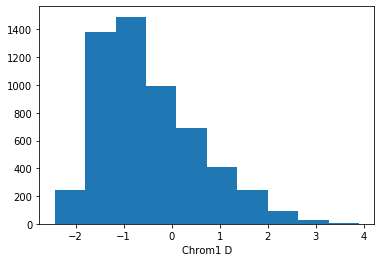

In [103]:
plt.hist(chrom1_stats['D'])
plt.xlabel("Chrom1 D")

-0.8206967018843893

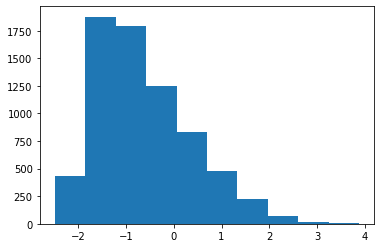

In [47]:
plt.hist(gene_results['D'])
gene_results['D'].mean()
gene_results['D'].median()

0.06554677167296598
0.05588317259426699


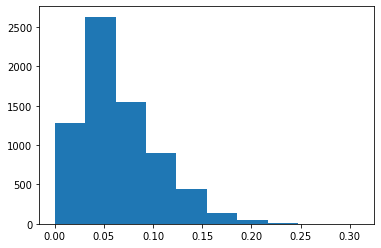

In [49]:
plt.hist(gene_results['Pi'])
plt.hist(pop)
print(gene_results['Pi'].mean())
print(gene_results['Pi'].median())

In [11]:
bed_g=bed_ready2.groupby(['name'])
vcf1.goto('1', position=egglib.io.FIRST)
sub=bed_g.get_group('AT1G01040')
sub
#sites=exon_search(1, 3760, 4800, vcf1)
combine_cds(sub, vcf1)
#cds=sum(sub['bedEnd']-sub['bedStart'])


{'gene': 'AT1G01040',
 'Pi': 1.7673475966154846,
 'D': -1.801742903554526,
 'lseff': 65,
 'cds_length': 5710}

In [105]:
chrom1_stats['D'].median()

-0.7042463420030481

0.06761792288907122

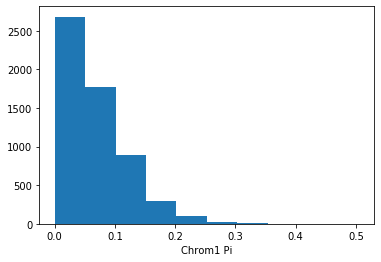

In [109]:
plt.hist(chrom1_stats['Pi'])
plt.xlabel("Chrom1 Pi")

chrom1_stats['Pi'].median()
chrom1_stats['Pi'].mean()

Gene level correlations

In [184]:
ln=0
with open('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/nlrome_partial.recode.vcf') as f:
    for line in f:
        ln += 1 
        if line.startswith('1\t'):
            #print('Line:')
            #print(line)
            #print('Position:')
            #print(line.split('\t')[1])
            position=int(line.split('\t')[1])
            #print(position)
            #print(position > 3996 and position < 4276)
            if position > 3996 and position < 4276:
                print(ln)
            else:
                continue
        else: 
            continue

501
502
503
504
505


In [118]:
vcf.goto('1', position=egglib.io.FIRST)
print(vcf.good)
next(vcf)
print(vcf.good)
v=vcf.get_variant()
v.GT_vcf
#vcf.goto('1', position=-1)

True
True


('0|0',
 '.',
 '.',
 '.',
 '0|0',
 '0|0',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '0|0',
 '0|0',
 '.',
 '0|0',
 '.',
 '0|0',
 '0|0',
 '0|0',
 '0|0',
 '.',
 '0|0',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '1|1',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '0|0',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.')

In [119]:
#vcf.unread()
#vcf.unread()
for i in vcf:
    i

OSError: cannot parse "VCF" data from "/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/toy.vcf" (line 966958): invalid GT field: 10|10

In [8]:
#explore the vcf file 
#samples 
print([vcf.get_sample(i) for i in range(vcf.num_samples)])
print('\n')
#alternative allele codes 
print([vcf.get_alt(i) for i in range(vcf.num_alt)])
print('\n')
#filter 
print([vcf.get_filter(i) for i in range(vcf.num_filter)])
print('\n')
#format 
print([vcf.get_format(i) for i in range(vcf.num_format)])
print('\n')
#info 
print([vcf.get_info(i) for i in range(vcf.num_info)])
print('\n')
#meta 
print([vcf.get_meta(i) for i in range(vcf.num_meta)])
print('\n')

['108', '1925', '5784', '5993', '6909', '6924', '6974', '6981', '7058', '7067', '7111', '7186', '7213', '7273', '7288', '7322', '7328', '7373', '7396', '7413', '7415', '7416', '7417', '9100', '9134', '9332', '9518', '9533', '9536', '9537', '9542', '9543', '9545', '9549', '9550', '9554', '9557', '9583', '9597', '9600', '9610', '9669', '9721', '9762', '9764', '9784', '9792', '9837', '9869', '9871', '9879', '9887', '9944', '9947', '10015']


[{'id': 'DEL', 'description': 'deletion relative to the reference', 'extra': []}, {'id': 'INS', 'description': 'insertion of novel sequence relative to the reference', 'extra': []}, {'id': 'DUP', 'description': 'region of elevated copy number relative to the reference', 'extra': []}, {'id': 'INV', 'description': 'inversion of reference sequence', 'extra': []}, {'id': 'CNV', 'description': 'copy number variable region (may be both deletion and duplication)', 'extra': []}, {'id': 'DUP:TANDEM', 'description': 'tandem duplication', 'extra': []}, {'id': 'D

In [10]:
#begin to extract site information from VCF 
#next is a global function that throws the first variant. If I re-run it prints new ones 
#output is chromosome name, position, then number of alleles including the reference allele 
next(vcf)

site=egglib.site_from_vcf(vcf)
print(site.as_list())

site.from_vcf(vcf)
print(site.as_list())
site.position

['C', 'C', '?', '?', '?', '?', '?', '?', 'C', 'C', 'C', 'C', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', 'C', 'C', 'C', 'C', '?', '?', 'C', 'C', '?', '?', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', '?', '?', 'C', 'C', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', 'T', 'T', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', 'C', 'C', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
['C', 'C', '?', '?', '?', '?', '?', '?', 'C', 'C', 'C', 'C', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', 'C', 'C', 'C', 'C', '?', '?', 'C', 'C', '?', '?', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', '?', '?', 'C', 'C', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', 'T', 'T', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?'

54.0

In [4]:
for ret in vcf:
    
    print(ret)

('1', 55, 2)
('1', 62, 2)
('1', 72, 2)
('1', 74, 2)
('1', 79, 2)
('1', 82, 3)
('1', 87, 2)
('1', 91, 2)
('1', 93, 2)
('1', 97, 2)
('1', 98, 3)
('1', 100, 2)
('1', 105, 2)
('1', 109, 2)
('1', 111, 2)
('1', 114, 3)
('1', 115, 2)
('1', 120, 3)
('1', 122, 2)
('1', 124, 2)
('1', 125, 2)
('1', 127, 2)
('1', 134, 2)
('1', 137, 2)
('1', 138, 2)
('1', 149, 2)
('1', 160, 2)
('1', 161, 2)
('1', 166, 2)
('1', 170, 2)
('1', 175, 2)
('1', 176, 3)
('1', 178, 2)
('1', 186, 2)
('1', 187, 2)
('1', 188, 3)
('1', 189, 2)
('1', 193, 2)
('1', 195, 2)
('1', 199, 3)
('1', 200, 2)
('1', 202, 2)
('1', 207, 2)
('1', 208, 2)
('1', 212, 2)
('1', 213, 3)
('1', 215, 3)
('1', 218, 2)
('1', 220, 2)
('1', 221, 2)
('1', 222, 2)
('1', 223, 3)
('1', 228, 2)
('1', 229, 3)
('1', 231, 2)
('1', 233, 3)
('1', 235, 3)
('1', 236, 2)
('1', 240, 2)
('1', 241, 2)
('1', 252, 2)
('1', 254, 2)
('1', 261, 3)
('1', 265, 2)
('1', 269, 2)
('1', 275, 2)
('1', 283, 2)
('1', 285, 2)
('1', 287, 2)
('1', 290, 2)
('1', 297, 2)
('1', 300, 2)
('1

('1', 8231, 2)
('1', 8245, 2)
('1', 8292, 2)
('1', 8328, 2)
('1', 8345, 2)
('1', 8359, 2)
('1', 8369, 2)
('1', 8378, 2)
('1', 8428, 2)
('1', 8465, 2)
('1', 8495, 3)
('1', 8525, 2)
('1', 8581, 2)
('1', 8616, 2)
('1', 8657, 2)
('1', 8658, 2)
('1', 8699, 2)
('1', 8706, 2)
('1', 8746, 2)
('1', 8752, 2)
('1', 8779, 2)
('1', 8780, 2)
('1', 8783, 2)
('1', 8790, 2)
('1', 8798, 2)
('1', 8808, 2)
('1', 8820, 2)
('1', 8827, 2)
('1', 8845, 2)
('1', 8859, 2)
('1', 8885, 2)
('1', 8915, 2)
('1', 8916, 2)
('1', 8924, 2)
('1', 8926, 2)
('1', 8928, 2)
('1', 8934, 2)
('1', 8942, 2)
('1', 8963, 2)
('1', 8964, 2)
('1', 8981, 2)
('1', 8989, 2)
('1', 9002, 2)
('1', 9025, 2)
('1', 9028, 2)
('1', 9037, 3)
('1', 9038, 2)
('1', 9045, 2)
('1', 9048, 2)
('1', 9073, 2)
('1', 9100, 2)
('1', 9121, 2)
('1', 9124, 2)
('1', 9127, 2)
('1', 9138, 2)
('1', 9153, 2)
('1', 9169, 2)
('1', 9173, 2)
('1', 9176, 2)
('1', 9184, 2)
('1', 9204, 2)
('1', 9213, 3)
('1', 9225, 2)
('1', 9231, 2)
('1', 9249, 2)
('1', 9255, 2)
('1', 9278

('1', 32805, 2)
('1', 32806, 2)
('1', 32814, 2)
('1', 32830, 2)
('1', 32837, 2)
('1', 32853, 2)
('1', 32904, 2)
('1', 32911, 2)
('1', 32923, 2)
('1', 32926, 2)
('1', 32933, 2)
('1', 32947, 2)
('1', 32950, 2)
('1', 32960, 2)
('1', 33013, 2)
('1', 33015, 2)
('1', 33022, 2)
('1', 33046, 2)
('1', 33067, 2)
('1', 33103, 2)
('1', 33112, 2)
('1', 33116, 2)
('1', 33122, 2)
('1', 33135, 2)
('1', 33186, 2)
('1', 33187, 2)
('1', 33196, 2)
('1', 33204, 2)
('1', 33206, 2)
('1', 33216, 2)
('1', 33223, 2)
('1', 33225, 2)
('1', 33240, 2)
('1', 33252, 2)
('1', 33253, 2)
('1', 33261, 2)
('1', 33277, 2)
('1', 33291, 2)
('1', 33313, 2)
('1', 33320, 2)
('1', 33321, 2)
('1', 33325, 2)
('1', 33367, 2)
('1', 33411, 2)
('1', 33430, 2)
('1', 33456, 2)
('1', 33458, 2)
('1', 33480, 2)
('1', 33483, 2)
('1', 33484, 2)
('1', 33514, 2)
('1', 33548, 2)
('1', 33551, 2)
('1', 33572, 2)
('1', 33596, 2)
('1', 33605, 2)
('1', 33608, 2)
('1', 33616, 2)
('1', 33646, 2)
('1', 33650, 2)
('1', 33654, 2)
('1', 33661, 2)
('1', 33

('1', 54680, 2)
('1', 54692, 2)
('1', 54702, 2)
('1', 54704, 2)
('1', 54710, 3)
('1', 54711, 2)
('1', 54712, 3)
('1', 54713, 3)
('1', 54714, 2)
('1', 54715, 2)
('1', 54737, 2)
('1', 54742, 2)
('1', 54756, 2)
('1', 54762, 2)
('1', 54767, 2)
('1', 54768, 2)
('1', 54776, 2)
('1', 54782, 2)
('1', 54801, 2)
('1', 54810, 2)
('1', 54851, 2)
('1', 54857, 2)
('1', 54861, 3)
('1', 54876, 2)
('1', 54880, 2)
('1', 54891, 2)
('1', 54893, 2)
('1', 54901, 2)
('1', 54916, 2)
('1', 54962, 2)
('1', 54991, 2)
('1', 54993, 2)
('1', 55009, 2)
('1', 55011, 2)
('1', 55012, 2)
('1', 55023, 2)
('1', 55032, 2)
('1', 55057, 2)
('1', 55060, 2)
('1', 55065, 2)
('1', 55078, 2)
('1', 55082, 2)
('1', 55089, 2)
('1', 55107, 2)
('1', 55121, 3)
('1', 55122, 2)
('1', 55124, 2)
('1', 55127, 2)
('1', 55145, 2)
('1', 55161, 2)
('1', 55170, 2)
('1', 55181, 2)
('1', 55191, 2)
('1', 55192, 2)
('1', 55210, 2)
('1', 55214, 2)
('1', 55215, 2)
('1', 55216, 3)
('1', 55223, 2)
('1', 55238, 2)
('1', 55240, 2)
('1', 55284, 2)
('1', 55

('1', 67131, 2)
('1', 67139, 2)
('1', 67142, 2)
('1', 67157, 2)
('1', 67166, 2)
('1', 67171, 2)
('1', 67179, 2)
('1', 67191, 2)
('1', 67199, 2)
('1', 67201, 2)
('1', 67217, 2)
('1', 67232, 2)
('1', 67241, 2)
('1', 67250, 2)
('1', 67269, 2)
('1', 67270, 2)
('1', 67271, 2)
('1', 67277, 2)
('1', 67281, 2)
('1', 67503, 2)
('1', 67515, 3)
('1', 67518, 2)
('1', 67535, 2)
('1', 67543, 2)
('1', 67565, 2)
('1', 67585, 2)
('1', 67588, 2)
('1', 67599, 2)
('1', 67601, 2)
('1', 67603, 2)
('1', 67605, 2)
('1', 67615, 2)
('1', 67650, 2)
('1', 67662, 2)
('1', 67672, 2)
('1', 67677, 2)
('1', 67684, 2)
('1', 67696, 3)
('1', 67711, 4)
('1', 67717, 2)
('1', 67725, 2)
('1', 67727, 2)
('1', 67765, 2)
('1', 67774, 2)
('1', 67789, 2)
('1', 67796, 2)
('1', 67810, 3)
('1', 67826, 2)
('1', 67840, 2)
('1', 67841, 2)
('1', 67847, 2)
('1', 67851, 2)
('1', 67859, 2)
('1', 67860, 2)
('1', 67875, 2)
('1', 67909, 2)
('1', 67912, 2)
('1', 67913, 2)
('1', 67939, 2)
('1', 67946, 2)
('1', 67969, 2)
('1', 67987, 2)
('1', 67

('1', 84596, 2)
('1', 84620, 2)
('1', 84693, 2)
('1', 84696, 2)
('1', 84697, 2)
('1', 84720, 2)
('1', 84740, 2)
('1', 84754, 2)
('1', 84784, 2)
('1', 84808, 2)
('1', 84879, 2)
('1', 84906, 2)
('1', 84907, 4)
('1', 84909, 2)
('1', 84914, 2)
('1', 84915, 2)
('1', 84927, 2)
('1', 84950, 2)
('1', 84973, 2)
('1', 84976, 2)
('1', 84988, 2)
('1', 85000, 2)
('1', 85037, 3)
('1', 85040, 2)
('1', 85114, 2)
('1', 85121, 2)
('1', 85148, 2)
('1', 85156, 2)
('1', 85193, 2)
('1', 85209, 2)
('1', 85213, 2)
('1', 85236, 2)
('1', 85258, 2)
('1', 85259, 2)
('1', 85262, 2)
('1', 85263, 2)
('1', 85275, 2)
('1', 85276, 2)
('1', 85285, 2)
('1', 85288, 2)
('1', 85298, 2)
('1', 85351, 2)
('1', 85353, 2)
('1', 85359, 3)
('1', 85360, 2)
('1', 85363, 2)
('1', 85394, 2)
('1', 85415, 2)
('1', 85425, 2)
('1', 85426, 2)
('1', 85433, 2)
('1', 85452, 2)
('1', 85455, 2)
('1', 85472, 2)
('1', 85506, 2)
('1', 85532, 2)
('1', 85533, 2)
('1', 85537, 2)
('1', 85560, 2)
('1', 85570, 2)
('1', 85575, 2)
('1', 85577, 2)
('1', 85

('1', 103103, 2)
('1', 103116, 2)
('1', 103117, 2)
('1', 103123, 2)
('1', 103138, 2)
('1', 103141, 2)
('1', 103169, 2)
('1', 103174, 2)
('1', 103184, 2)
('1', 103202, 2)
('1', 103215, 2)
('1', 103232, 2)
('1', 103243, 2)
('1', 103254, 2)
('1', 103275, 2)
('1', 103276, 2)
('1', 103283, 2)
('1', 103297, 2)
('1', 103312, 2)
('1', 103318, 2)
('1', 103329, 2)
('1', 103342, 2)
('1', 103360, 2)
('1', 103363, 2)
('1', 103365, 3)
('1', 103371, 2)
('1', 103382, 2)
('1', 103433, 2)
('1', 103452, 2)
('1', 103462, 2)
('1', 103473, 2)
('1', 103519, 2)
('1', 103526, 2)
('1', 103529, 2)
('1', 103542, 2)
('1', 103543, 2)
('1', 103559, 2)
('1', 103567, 2)
('1', 103609, 2)
('1', 103627, 2)
('1', 103639, 2)
('1', 103653, 2)
('1', 103675, 2)
('1', 103681, 2)
('1', 103683, 2)
('1', 103684, 2)
('1', 103694, 2)
('1', 103714, 2)
('1', 103748, 2)
('1', 103759, 2)
('1', 103765, 2)
('1', 103766, 2)
('1', 103778, 2)
('1', 103791, 2)
('1', 103797, 2)
('1', 103798, 2)
('1', 103801, 2)
('1', 103802, 2)
('1', 103803, 

('1', 122486, 2)
('1', 122502, 2)
('1', 122509, 2)
('1', 122601, 2)
('1', 122602, 2)
('1', 122609, 2)
('1', 122613, 2)
('1', 122618, 2)
('1', 122640, 2)
('1', 122644, 2)
('1', 122698, 2)
('1', 122706, 2)
('1', 122712, 2)
('1', 122718, 2)
('1', 122746, 2)
('1', 122782, 2)
('1', 122808, 2)
('1', 122818, 2)
('1', 122824, 2)
('1', 122839, 2)
('1', 122872, 2)
('1', 122886, 2)
('1', 122887, 2)
('1', 122922, 2)
('1', 123011, 2)
('1', 123040, 2)
('1', 123050, 2)
('1', 123067, 2)
('1', 123076, 2)
('1', 123173, 2)
('1', 123194, 2)
('1', 123205, 2)
('1', 123250, 2)
('1', 123263, 2)
('1', 123275, 2)
('1', 123276, 2)
('1', 123282, 2)
('1', 123290, 2)
('1', 123312, 2)
('1', 123330, 2)
('1', 123346, 2)
('1', 123368, 2)
('1', 123369, 2)
('1', 123412, 2)
('1', 123440, 2)
('1', 123462, 2)
('1', 123483, 2)
('1', 123495, 2)
('1', 123505, 2)
('1', 123516, 2)
('1', 123536, 2)
('1', 123543, 2)
('1', 123544, 2)
('1', 123564, 2)
('1', 123571, 2)
('1', 123611, 2)
('1', 123621, 2)
('1', 123628, 2)
('1', 123656, 

('1', 146383, 2)
('1', 146388, 2)
('1', 146397, 2)
('1', 146414, 2)
('1', 146450, 2)
('1', 146456, 2)
('1', 146470, 2)
('1', 146472, 2)
('1', 146488, 2)
('1', 146490, 2)
('1', 146497, 2)
('1', 146498, 2)
('1', 146510, 2)
('1', 146544, 2)
('1', 146547, 3)
('1', 146551, 2)
('1', 146562, 2)
('1', 146605, 2)
('1', 146606, 2)
('1', 146617, 2)
('1', 146618, 2)
('1', 146642, 2)
('1', 146646, 2)
('1', 146657, 2)
('1', 146692, 2)
('1', 146704, 2)
('1', 146708, 2)
('1', 146716, 2)
('1', 146719, 2)
('1', 146733, 2)
('1', 146736, 2)
('1', 146738, 3)
('1', 146748, 4)
('1', 146749, 2)
('1', 146776, 3)
('1', 146828, 2)
('1', 146851, 2)
('1', 146852, 2)
('1', 146853, 2)
('1', 146871, 2)
('1', 146908, 2)
('1', 146924, 2)
('1', 146948, 3)
('1', 146953, 2)
('1', 147018, 2)
('1', 147105, 2)
('1', 147109, 2)
('1', 147127, 2)
('1', 147130, 2)
('1', 147131, 2)
('1', 147156, 2)
('1', 147196, 2)
('1', 147197, 2)
('1', 147212, 2)
('1', 147216, 2)
('1', 147219, 2)
('1', 147232, 2)
('1', 147233, 2)
('1', 147235, 

('1', 165759, 2)
('1', 165765, 2)
('1', 165772, 2)
('1', 165796, 2)
('1', 165863, 2)
('1', 165892, 2)
('1', 165904, 2)
('1', 165912, 2)
('1', 165929, 2)
('1', 165975, 2)
('1', 165983, 2)
('1', 165999, 2)
('1', 166018, 2)
('1', 166029, 2)
('1', 166033, 2)
('1', 166060, 2)
('1', 166070, 2)
('1', 166094, 2)
('1', 166105, 2)
('1', 166106, 2)
('1', 166132, 2)
('1', 166149, 2)
('1', 166155, 2)
('1', 166162, 3)
('1', 166165, 3)
('1', 166178, 2)
('1', 166183, 3)
('1', 166218, 2)
('1', 166220, 2)
('1', 166233, 2)
('1', 166250, 2)
('1', 166252, 2)
('1', 166256, 2)
('1', 166265, 2)
('1', 166270, 2)
('1', 166275, 2)
('1', 166276, 2)
('1', 166292, 2)
('1', 166302, 2)
('1', 166303, 2)
('1', 166316, 2)
('1', 166329, 2)
('1', 166333, 2)
('1', 166345, 2)
('1', 166348, 2)
('1', 166372, 2)
('1', 166385, 2)
('1', 166400, 2)
('1', 166409, 2)
('1', 166429, 2)
('1', 166437, 2)
('1', 166464, 2)
('1', 166484, 2)
('1', 166532, 2)
('1', 166546, 2)
('1', 166554, 2)
('1', 166555, 2)
('1', 166571, 2)
('1', 166576, 

('1', 182113, 2)
('1', 182121, 2)
('1', 182132, 2)
('1', 182137, 2)
('1', 182138, 2)
('1', 182146, 4)
('1', 182174, 2)
('1', 182179, 2)
('1', 182185, 2)
('1', 182191, 2)
('1', 182197, 2)
('1', 182211, 2)
('1', 182224, 2)
('1', 182241, 2)
('1', 182249, 2)
('1', 182251, 2)
('1', 182252, 2)
('1', 182263, 2)
('1', 182271, 2)
('1', 182283, 2)
('1', 182299, 2)
('1', 182300, 2)
('1', 182315, 2)
('1', 182322, 2)
('1', 182329, 5)
('1', 182334, 2)
('1', 182353, 2)
('1', 182360, 3)
('1', 182372, 2)
('1', 182391, 2)
('1', 182392, 2)
('1', 182396, 2)
('1', 182403, 2)
('1', 182408, 2)
('1', 182434, 2)
('1', 182480, 3)
('1', 182488, 2)
('1', 182500, 2)
('1', 182505, 2)
('1', 182513, 2)
('1', 182551, 2)
('1', 182566, 2)
('1', 182568, 2)
('1', 182572, 2)
('1', 182581, 2)
('1', 182583, 2)
('1', 182584, 2)
('1', 182589, 2)
('1', 182602, 2)
('1', 182604, 2)
('1', 182612, 2)
('1', 182616, 2)
('1', 182617, 2)
('1', 182622, 2)
('1', 182623, 2)
('1', 182629, 2)
('1', 182632, 2)
('1', 182641, 2)
('1', 182647, 

('1', 205458, 2)
('1', 205540, 2)
('1', 205543, 2)
('1', 205561, 2)
('1', 205621, 2)
('1', 205638, 2)
('1', 205671, 2)
('1', 205709, 2)
('1', 205729, 2)
('1', 205738, 2)
('1', 205741, 2)
('1', 205760, 2)
('1', 205769, 2)
('1', 205780, 2)
('1', 205795, 2)
('1', 205796, 2)
('1', 205797, 2)
('1', 205818, 2)
('1', 205821, 2)
('1', 205830, 2)
('1', 205864, 2)
('1', 205870, 2)
('1', 205905, 2)
('1', 205934, 2)
('1', 205976, 2)
('1', 205989, 2)
('1', 206000, 2)
('1', 206007, 2)
('1', 206010, 2)
('1', 206023, 2)
('1', 206024, 3)
('1', 206025, 2)
('1', 206030, 2)
('1', 206046, 2)
('1', 206068, 2)
('1', 206099, 2)
('1', 206117, 2)
('1', 206133, 2)
('1', 206135, 2)
('1', 206162, 2)
('1', 206167, 2)
('1', 206178, 2)
('1', 206189, 2)
('1', 206191, 2)
('1', 206211, 2)
('1', 206214, 2)
('1', 206228, 2)
('1', 206229, 3)
('1', 206231, 2)
('1', 206233, 2)
('1', 206235, 2)
('1', 206236, 2)
('1', 206238, 2)
('1', 206256, 2)
('1', 206259, 2)
('1', 206266, 2)
('1', 206269, 3)
('1', 206272, 2)
('1', 206273, 

('1', 219637, 2)
('1', 219642, 2)
('1', 219647, 2)
('1', 219684, 2)
('1', 219692, 2)
('1', 219699, 2)
('1', 219708, 2)
('1', 219713, 2)
('1', 219715, 2)
('1', 219763, 2)
('1', 219775, 2)
('1', 219799, 2)
('1', 219811, 2)
('1', 219839, 2)
('1', 219880, 2)
('1', 219889, 2)
('1', 219922, 2)
('1', 220063, 2)
('1', 220081, 2)
('1', 220082, 2)
('1', 220105, 2)
('1', 220106, 2)
('1', 220126, 2)
('1', 220151, 2)
('1', 220156, 2)
('1', 220162, 2)
('1', 220187, 2)
('1', 220218, 2)
('1', 220233, 2)
('1', 220234, 2)
('1', 220237, 2)
('1', 220238, 2)
('1', 220264, 2)
('1', 220277, 2)
('1', 220333, 2)
('1', 220336, 2)
('1', 220340, 2)
('1', 220349, 2)
('1', 220413, 2)
('1', 220424, 2)
('1', 220445, 2)
('1', 220477, 2)
('1', 220483, 2)
('1', 220608, 2)
('1', 220645, 2)
('1', 220651, 2)
('1', 220663, 2)
('1', 220738, 2)
('1', 220749, 2)
('1', 220755, 2)
('1', 220756, 2)
('1', 220770, 2)
('1', 220807, 2)
('1', 220859, 2)
('1', 220860, 2)
('1', 220867, 2)
('1', 220885, 2)
('1', 220894, 2)
('1', 220919, 

('1', 242322, 2)
('1', 242328, 2)
('1', 242335, 2)
('1', 242352, 2)
('1', 242365, 2)
('1', 242367, 2)
('1', 242393, 2)
('1', 242394, 2)
('1', 242395, 2)
('1', 242410, 2)
('1', 242421, 2)
('1', 242428, 2)
('1', 242432, 2)
('1', 242436, 2)
('1', 242437, 2)
('1', 242453, 2)
('1', 242500, 3)
('1', 242503, 2)
('1', 242542, 2)
('1', 242558, 2)
('1', 242602, 2)
('1', 242612, 2)
('1', 242620, 2)
('1', 242625, 2)
('1', 242639, 2)
('1', 242677, 2)
('1', 242701, 2)
('1', 242705, 2)
('1', 242715, 2)
('1', 242806, 2)
('1', 242814, 2)
('1', 242835, 3)
('1', 242843, 2)
('1', 242844, 2)
('1', 242862, 2)
('1', 242880, 2)
('1', 242910, 2)
('1', 242957, 2)
('1', 243011, 2)
('1', 243052, 2)
('1', 243100, 2)
('1', 243148, 2)
('1', 243169, 2)
('1', 243172, 2)
('1', 243176, 2)
('1', 243184, 2)
('1', 243186, 2)
('1', 243191, 2)
('1', 243202, 2)
('1', 243205, 3)
('1', 243208, 2)
('1', 243213, 2)
('1', 243216, 2)
('1', 243220, 2)
('1', 243224, 2)
('1', 243232, 2)
('1', 243263, 2)
('1', 243279, 2)
('1', 243292, 

('1', 257503, 2)
('1', 257515, 2)
('1', 257540, 2)
('1', 257543, 2)
('1', 257544, 2)
('1', 257550, 2)
('1', 257553, 2)
('1', 257554, 2)
('1', 257559, 2)
('1', 257563, 2)
('1', 257568, 2)
('1', 257572, 2)
('1', 257576, 2)
('1', 257584, 2)
('1', 257588, 3)
('1', 257589, 2)
('1', 257597, 3)
('1', 257603, 2)
('1', 257604, 2)
('1', 257606, 2)
('1', 257607, 4)
('1', 257611, 2)
('1', 257615, 2)
('1', 257619, 2)
('1', 257623, 2)
('1', 257631, 2)
('1', 257637, 2)
('1', 257638, 3)
('1', 257648, 2)
('1', 257652, 2)
('1', 257653, 2)
('1', 257655, 3)
('1', 257656, 2)
('1', 257660, 2)
('1', 257662, 2)
('1', 257663, 2)
('1', 257664, 2)
('1', 257668, 3)
('1', 257669, 2)
('1', 257670, 2)
('1', 257672, 2)
('1', 257673, 2)
('1', 257674, 2)
('1', 257678, 3)
('1', 257681, 2)
('1', 257683, 2)
('1', 257687, 2)
('1', 257692, 2)
('1', 257696, 2)
('1', 257697, 2)
('1', 257702, 2)
('1', 257704, 2)
('1', 257709, 2)
('1', 257710, 2)
('1', 257711, 3)
('1', 257713, 2)
('1', 257716, 3)
('1', 257719, 2)
('1', 257720, 

('1', 278850, 2)
('1', 278860, 2)
('1', 278865, 2)
('1', 278871, 2)
('1', 278896, 2)
('1', 278898, 2)
('1', 278904, 2)
('1', 278910, 2)
('1', 278943, 2)
('1', 278973, 2)
('1', 278993, 2)
('1', 278999, 2)
('1', 279040, 2)
('1', 279044, 2)
('1', 279048, 2)
('1', 279054, 3)
('1', 279112, 2)
('1', 279117, 2)
('1', 279118, 2)
('1', 279119, 3)
('1', 279125, 2)
('1', 279134, 2)
('1', 279138, 2)
('1', 279159, 2)
('1', 279169, 2)
('1', 279187, 2)
('1', 279191, 2)
('1', 279192, 2)
('1', 279194, 2)
('1', 279207, 2)
('1', 279254, 2)
('1', 279255, 2)
('1', 279261, 2)
('1', 279284, 2)
('1', 279300, 2)
('1', 279310, 2)
('1', 279324, 2)
('1', 279339, 2)
('1', 279381, 2)
('1', 279384, 3)
('1', 279394, 2)
('1', 279434, 2)
('1', 279438, 2)
('1', 279458, 2)
('1', 279459, 2)
('1', 279461, 2)
('1', 279468, 2)
('1', 279476, 2)
('1', 279477, 2)
('1', 279496, 2)
('1', 279505, 2)
('1', 279511, 2)
('1', 279527, 2)
('1', 279530, 2)
('1', 279549, 2)
('1', 279570, 2)
('1', 279574, 2)
('1', 279609, 3)
('1', 279618, 

('1', 297223, 2)
('1', 297230, 2)
('1', 297244, 3)
('1', 297245, 2)
('1', 297279, 2)
('1', 297281, 2)
('1', 297283, 2)
('1', 297293, 2)
('1', 297355, 3)
('1', 297380, 2)
('1', 297414, 2)
('1', 297420, 2)
('1', 297456, 2)
('1', 297457, 2)
('1', 297458, 2)
('1', 297461, 2)
('1', 297481, 2)
('1', 297487, 2)
('1', 297490, 2)
('1', 297493, 2)
('1', 297496, 2)
('1', 297497, 2)
('1', 297498, 2)
('1', 297505, 2)
('1', 297516, 2)
('1', 297519, 2)
('1', 297526, 2)
('1', 297534, 2)
('1', 297565, 2)
('1', 297590, 2)
('1', 297606, 2)
('1', 297687, 2)
('1', 297705, 2)
('1', 297737, 2)
('1', 297748, 2)
('1', 297760, 2)
('1', 297768, 2)
('1', 297770, 2)
('1', 297790, 2)
('1', 297793, 2)
('1', 297803, 2)
('1', 297813, 2)
('1', 297831, 2)
('1', 297834, 2)
('1', 297851, 2)
('1', 297860, 2)
('1', 297866, 2)
('1', 297876, 2)
('1', 297880, 2)
('1', 297896, 2)
('1', 297912, 2)
('1', 297934, 2)
('1', 297945, 2)
('1', 297949, 3)
('1', 297978, 2)
('1', 297982, 2)
('1', 297997, 2)
('1', 298002, 2)
('1', 298016, 

('1', 325148, 2)
('1', 325156, 2)
('1', 325158, 2)
('1', 325160, 2)
('1', 325165, 2)
('1', 325167, 2)
('1', 325186, 2)
('1', 325195, 2)
('1', 325198, 2)
('1', 325201, 2)
('1', 325202, 2)
('1', 325208, 2)
('1', 325210, 2)
('1', 325212, 2)
('1', 325218, 2)
('1', 325220, 2)
('1', 325237, 2)
('1', 325243, 2)
('1', 325325, 2)
('1', 325339, 2)
('1', 325346, 2)
('1', 325364, 2)
('1', 325368, 2)
('1', 325399, 2)
('1', 325405, 2)
('1', 325485, 2)
('1', 325525, 2)
('1', 325545, 2)
('1', 325597, 2)
('1', 325614, 2)
('1', 325634, 2)
('1', 325635, 2)
('1', 325647, 2)
('1', 325653, 2)
('1', 325668, 2)
('1', 325677, 2)
('1', 325685, 2)
('1', 325702, 2)
('1', 325712, 2)
('1', 325713, 2)
('1', 325798, 2)
('1', 325806, 2)
('1', 325816, 2)
('1', 325827, 2)
('1', 325829, 2)
('1', 325837, 3)
('1', 325846, 2)
('1', 325851, 2)
('1', 325853, 2)
('1', 325854, 2)
('1', 325861, 2)
('1', 325884, 3)
('1', 325886, 2)
('1', 325900, 2)
('1', 325902, 2)
('1', 325957, 2)
('1', 326001, 2)
('1', 326007, 2)
('1', 326021, 

KeyboardInterrupt: 

In [7]:
gtf='/global/scratch/users/chandlersutherland/Athaliana/GTFs/Araport11_GTF_genes_transposons.current.gtf'
gtf_import=pd.read_csv(gtf,sep='\t', skiprows=3).reset_index()
gtf_import=gtf_import.rename(columns={"level_0": "chrom", "level_1": "Genome", "level_2" : "type", "level_3" : "chromStart", "level_4":"chromEnd", "level_6":'strand'})
#gtf_import=gtf_import[gtf_import['type'] == 'gene']
gtf_import
gtf_import['name'] = gtf_import['##GTF'].str.split(';',expand=True)[1].str.split(' ', expand=True)[2].str.replace('"', '')
gtf_import['transcript_id']=gtf_import['##GTF'].str.split(';',expand=True)[0].str.split(' ', expand=True)[1].str.strip('"').str.split('.', expand=True)[1]

# bed_ready = gtf_import.drop(['Genome', 'type', 'level_5', 'level_7', '##GTF'], axis=1)
# bed_ready['chrom'].replace('Chr', '')

cds_import=gtf_import[gtf_import['type'] == 'CDS']
cds_import['name'] = cds_import['##GTF'].str.split(';',expand=True)[1].str.split(' ', expand=True)[2].str.replace('"', '')
cds_import['transcript_id']=cds_import['##GTF'].str.split(';',expand=True)[0].str.split(' ', expand=True)[1].str.strip('"').str.split('.', expand=True)[1]
cds_import['chrom']=cds_import['chrom'].str.replace('Chr', '')
cds_import=cds_import[cds_import['transcript_id']=='1']

bed_ready2 = cds_import.drop(['Genome', 'type', 'level_5', 'level_7', '##GTF'], axis=1)
bed_ready2

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,chrom,chromStart,chromEnd,strand,name,transcript_id
2,1,3760,3913,+,AT1G01010,1
3,1,3996,4276,+,AT1G01010,1
4,1,4486,4605,+,AT1G01010,1
5,1,4706,5095,+,AT1G01010,1
6,1,5174,5326,+,AT1G01010,1
...,...,...,...,...,...,...
927346,M,67098,68621,-,ATMG01190,1
927349,M,79559,80005,+,ATMG01270,1
927352,M,58315,58397,+,ATMG01275,1
927353,M,59290,59481,+,ATMG01275,1


In [67]:
test=gtf_import[gtf_import['name']=='AT1G01040']
#test=test[test['type']=='CDS']
test['transcript_id']=test['##GTF'].str.split(';',expand=True)[0].str.split(' ', expand=True)[1].str.strip('"').str.split('.', expand=True)[1]
test

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,chrom,Genome,type,chromStart,chromEnd,level_5,strand,level_7,##GTF,name,transcript_id
157,Chr1,Araport11,gene,23121,31227,.,+,.,"transcript_id ""AT1G01040""; gene_id ""AT1G01040"";",AT1G01040,None
158,Chr1,Araport11,mRNA,23121,31227,.,+,.,"transcript_id ""AT1G01040.1""; gene_id ""AT1G01040"";",AT1G01040,1
159,Chr1,Araport11,CDS,23519,24451,.,+,0,"transcript_id ""AT1G01040.1""; gene_id ""AT1G01040"";",AT1G01040,1
160,Chr1,Araport11,CDS,24542,24655,.,+,0,"transcript_id ""AT1G01040.1""; gene_id ""AT1G01040"";",AT1G01040,1
161,Chr1,Araport11,CDS,24752,24962,.,+,0,"transcript_id ""AT1G01040.1""; gene_id ""AT1G01040"";",AT1G01040,1
...,...,...,...,...,...,...,...,...,...,...,...
241,Chr1,Araport11,exon,30410,30816,.,+,.,"transcript_id ""AT1G01040.2""; gene_id ""AT1G01040"";",AT1G01040,2
242,Chr1,Araport11,exon,30902,31120,.,+,.,"transcript_id ""AT1G01040.2""; gene_id ""AT1G01040"";",AT1G01040,2
243,Chr1,Araport11,five_prime_UTR,23416,23518,.,+,.,"transcript_id ""AT1G01040.2""; gene_id ""AT1G01040"";",AT1G01040,2
244,Chr1,Araport11,protein,23519,31079,.,+,.,"transcript_id ""AT1G01040.2""; gene_id ""AT1G01040"";",AT1G01040,2


In [44]:
bed=egglib.io.BED("/global/scratch/users/chandlersutherland/Athaliana/Atha_cds.bed")
egglib.io.make_vcf_index('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/1001genomes_snp-short-indel_only_ACGTN.vcf')

'/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/1001genomes_snp-short-indel_only_ACGTN.vcfi'

In [175]:
vcf.load_index('/global/scratch/users/chandlersutherland/e14/popgen/vcf_1001/toy.vcfi')
bed_slide=vcf.bed_slider(bed)

In [120]:
bed_slide

In [178]:
bed[1]
# for pos in vcf:
#     try: 
#         if pos[0] == 1: 
#             if pos[1] > 3996 & pos[1] < 4276:
#                 print(pos)
#         else: 
#             continue
#     except: 
#         pass
    
while vcf.good:
    for pos in vcf:
        if pos[0] == 1:
            if pos[1] > 3996 & pos[1] < 4276:
                print(pos)
        else:
            continue

KeyboardInterrupt: 

In [177]:
bed
len(bed)
print(bed[1])
#vcf.has_index
vcf.goto('1', position=egglib.io.FIRST)
print(vcf.get_variant().alleles)
print(vcf.get_variant().position)
next(vcf)
print(vcf.get_variant().alleles)
print(vcf.get_variant().position)
next(vcf)
print(vcf.get_variant().alleles)
print(vcf.get_variant().position)
vcf.goto('1', 55)

{'chrom': '1', 'start': 3996, 'end': 4276}


ValueError: cannot generate `VcfVariant` instance: no VCF line has been parsed (or the length of the reference allele is null)

In [169]:
#egglib.site_from_vcf(vcf, 0, 55)
vcf

In [ ]:
vcf.goto('1', position=egglib.io.FIRST)
array=[]
for i in range(500,506):
    next(vcf)
    print(vcf.get_variant().position)
    print(vcf.get_variant().chromosome)
    site=vcf.get_genotypes()
    array.append(site)

cs.clear_stats()
cs.add_stats('S', 'nseff', 'lseff', 'D')
print(cs.process_sites(array))

In [ ]:
vcf.goto('1', position=egglib.io.FIRST)
array=[]
bed_chrom=1
bed_start=3990
bed_end=4280
for i in vcf:
    chrom, pos, nall = next(vcf)
    if int(chrom) == bed_chrom:
        if pos >= bed_start and pos <= bed_end:
            print(vcf.get_variant().position)
            print(vcf.get_variant().chromosome)
            #print(vcf.get_variant().)
            site=vcf.get_genotypes()
            array.append(site)

In [30]:
bed=egglib.io.BED("/global/scratch/users/chandlersutherland/Athaliana/Atha_cds.bed")

sld=vcf1.bed_slider(bed)
cs=egglib.stats.ComputeStats()
cs.add_stats('S', 'eta', 'Pi', 'D', 'lseff')

with open('stats.txt', 'w') as f:
    for gene in sld: 
        f.write('{O[S]} {O[lseff]} {O[eta]} {O[Pi]} {O[D]}\n'.format(cs.process_sites(gene)))

ValueError: cannot find specified variant